# Import the CUHK CompCars Dataset and Upload the relevant files to Colab

In [ ]:
! pip install -q kaggle

In [ ]:
# Get keys from .env

import os
from dotenv import load_dotenv

load_dotenv()

kaggle: dict[str, str] = {
    "username": os.environ["KAGGLE_USERNAME"],
    "key": os.environ["KAGGLE_KEY"]
}

In [ ]:
# Save file into Kaggle directory

import json

os.makedirs(".kaggle", exist_ok=True)

with open(".kaggle/kaggle.json", "w") as f:
  json.dump(kaggle, f)

In [ ]:
# ! kaggle datasets download -d renancostaalencar/compcars

In [ ]:
# ! unzip -q -o compcars.zip

## Create a directory of all images and labels

In [1]:
import os

# Images

images = []
for root, dir, files in os.walk("image"):
    if files:
        for f in files:
            images.append((f[:-4], os.path.join(root, f)))

# Labels

labels = []
for root, dir, files in os.walk("label"):
    if files:
        for f in files:
            labels.append((f[:-4], os.path.join(root, f)))

## Load in labels and attributes by class

The main knowledge for this comes from a published paper, [Revisiting the CompCars Dataset for Hierarchical Car Classification: New Annotations, Experiments, and Results](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7830427/).

Namely, the "Original Cardinality" metrics from the following chart, which align to the counts observed in our data.

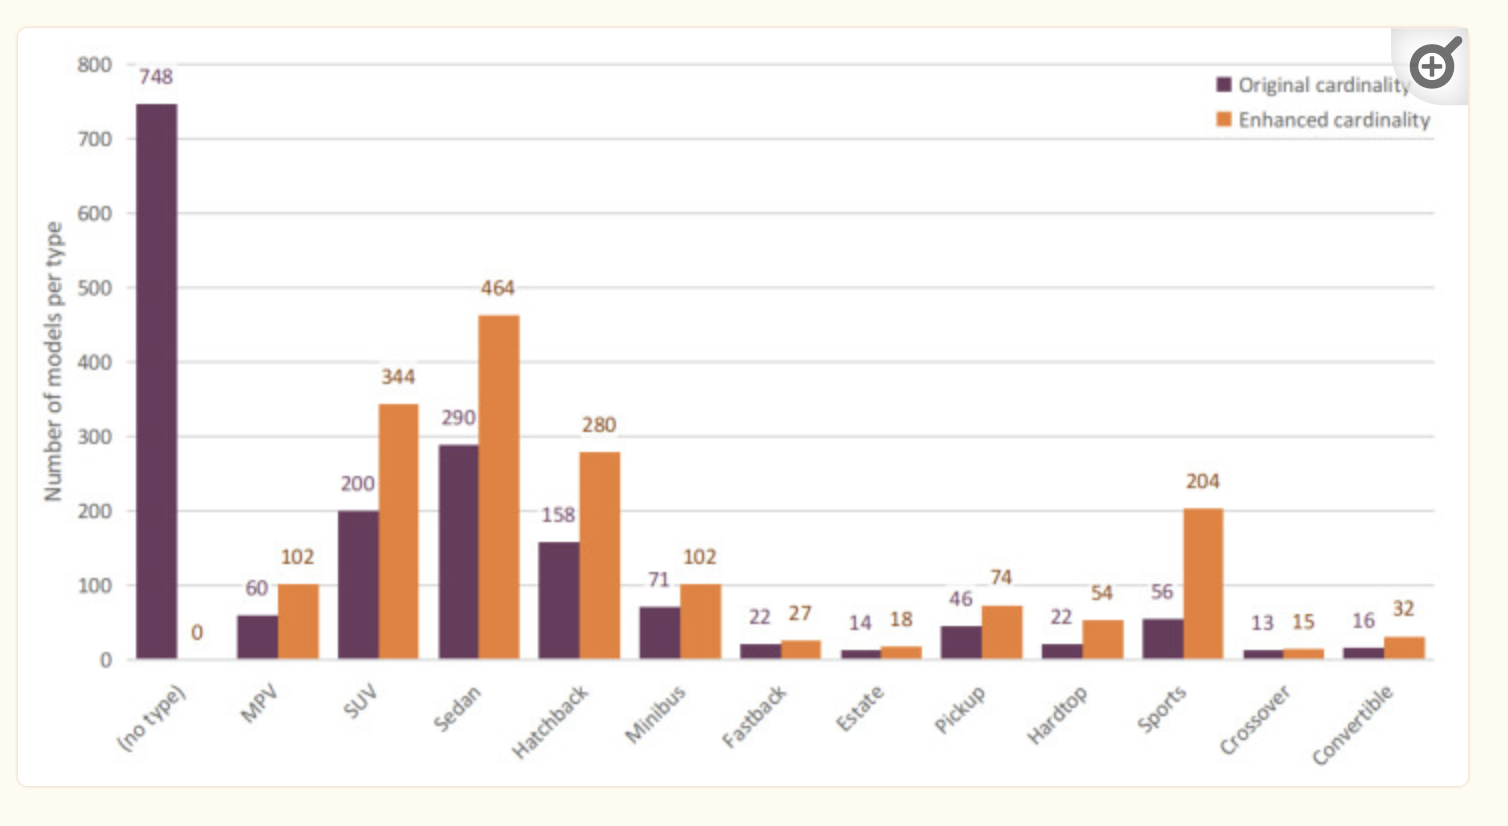

In [2]:
# Load in the types

from scipy.io import loadmat

car_type = loadmat("misc/car_type.mat")
car_type = car_type["types"][0]
car_type = [(i, t[0]) for i, t in enumerate(car_type)]

In [3]:
# Load in the attributes

import pandas as pd

with open("misc/attributes.txt", "r") as f:
    attributes = f.readlines()
attributes_cols = attributes[0].split()
attributes_data = [row.split() for row in attributes[1:]]
df_attributes = pd.DataFrame(attributes_data, columns=attributes_cols)
df_attributes.head()

,model_id,maximum_speed,displacement,door_number,seat_number,type
0,1,235,1.8,5,5,4
1,2,220,1.8,4,5,3
2,3,228,2.0,4,5,3
3,4,230,2.0,5,5,2
4,5,234,3.0,5,5,2


In [4]:
# How many distinct attributes? 

distinct_models = len(df_attributes["model_id"].drop_duplicates())
print(f"{distinct_models:,.0f} distinct models")

distinct_image_paths = len(list(set([im[1].split("/")[2] for im in images])))
print(f"{distinct_image_paths:,.0f} distinct image folders")

1,716 distinct models
1,716 distinct image folders


In [5]:
# Scope the available types
# Note that the counts align to the chart from the paper

df_types = pd.DataFrame(df_attributes["type"].value_counts()).reset_index()
df_types["type"] = df_types["type"].apply(int)
df_types

,type,count
0,0,748
1,3,290
2,2,200
3,4,158
4,5,71
5,1,60
6,10,56
7,8,46
8,6,22
9,9,22


In [6]:
# Scope the available types

type_labels = []
for t in df_types["type"]:
    if t > 0:
        type_labels.append(car_type[t-1][1])
    else:
        type_labels.append("unknown")

df_types.loc[:, "label"] = type_labels

df_types

,type,count,label
0,0,748,unknown
1,3,290,sedan
2,2,200,SUV
3,4,158,hatchback
4,5,71,minibus
5,1,60,MPV
6,10,56,sports
7,8,46,pickup
8,6,22,fastback
9,9,22,hardtop convertible


In [7]:
# Add labels to attributes

df_attributes["type"] = df_attributes["type"].apply(int)

type_labels = []
for t in df_attributes["type"]:
    if t > 0:
        type_labels.append(car_type[t-1][1])
    else:
        type_labels.append("unknown")

df_attributes.loc[:, "label"] = type_labels

df_attributes.head()

,model_id,maximum_speed,displacement,door_number,seat_number,type,label
0,1,235,1.8,5,5,4,hatchback
1,2,220,1.8,4,5,3,sedan
2,3,228,2.0,4,5,3,sedan
3,4,230,2.0,5,5,2,SUV
4,5,234,3.0,5,5,2,SUV


## Check on each car type as a QC

Type #1: MPV


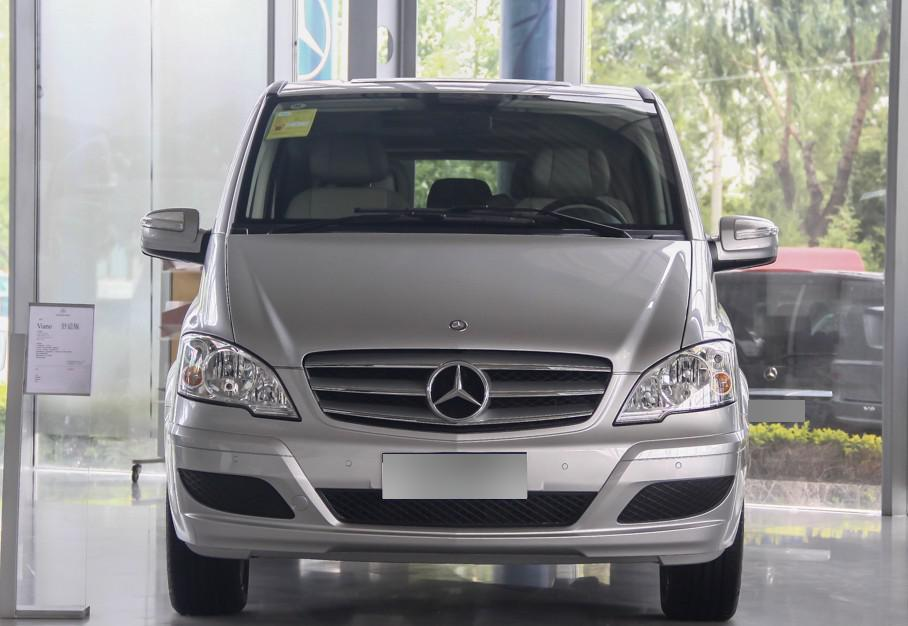

Type #2: SUV


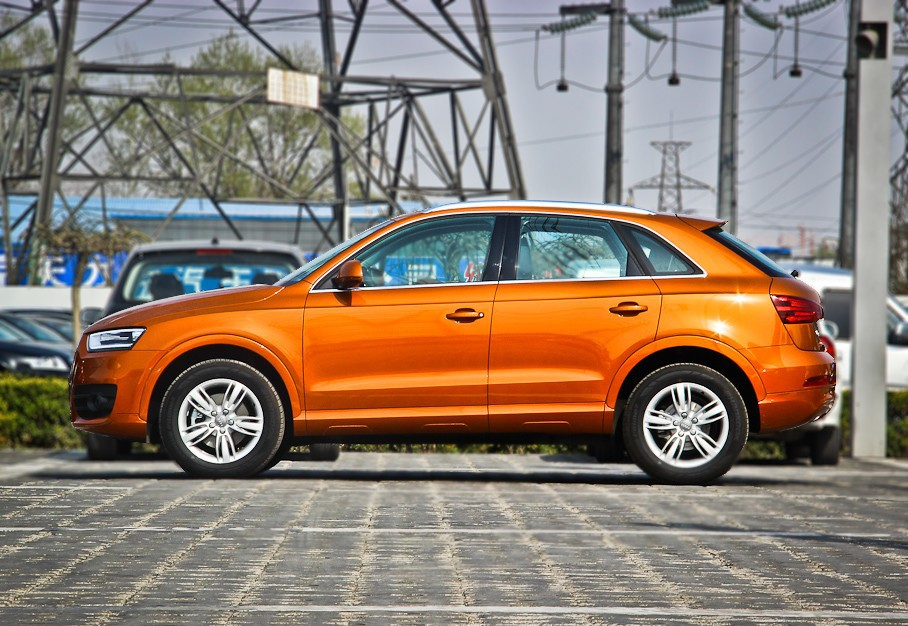

Type #3: sedan


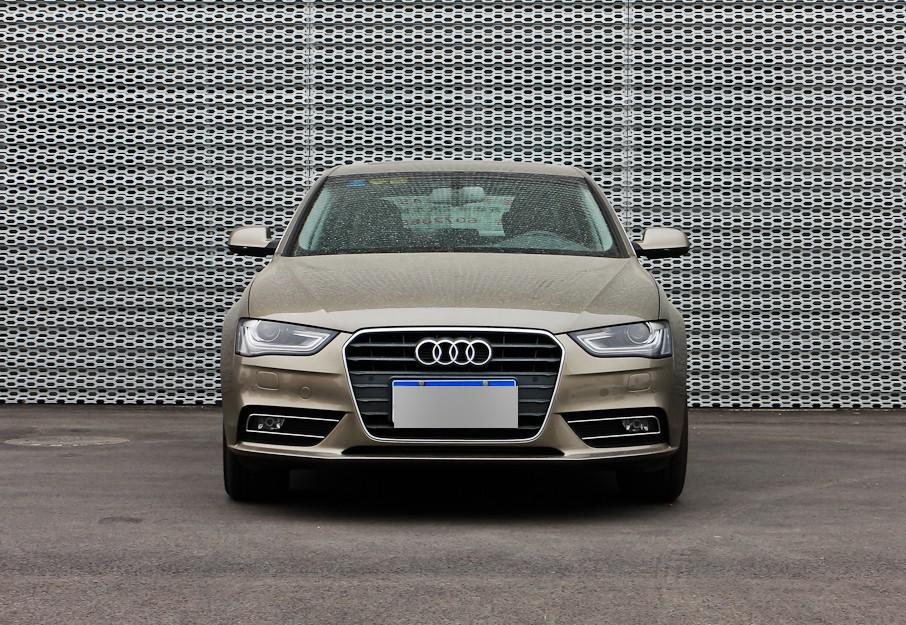

Type #4: hatchback


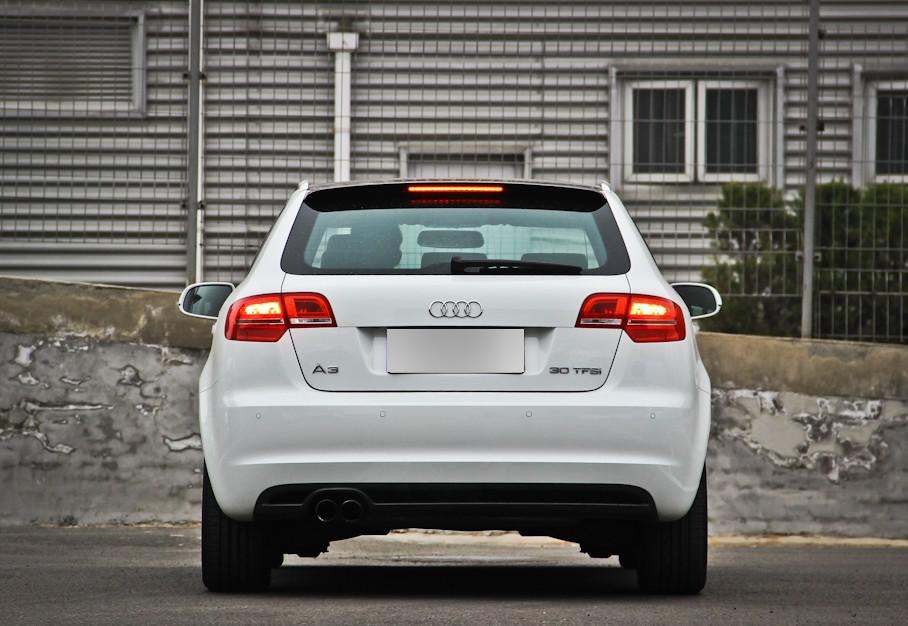

Type #5: minibus


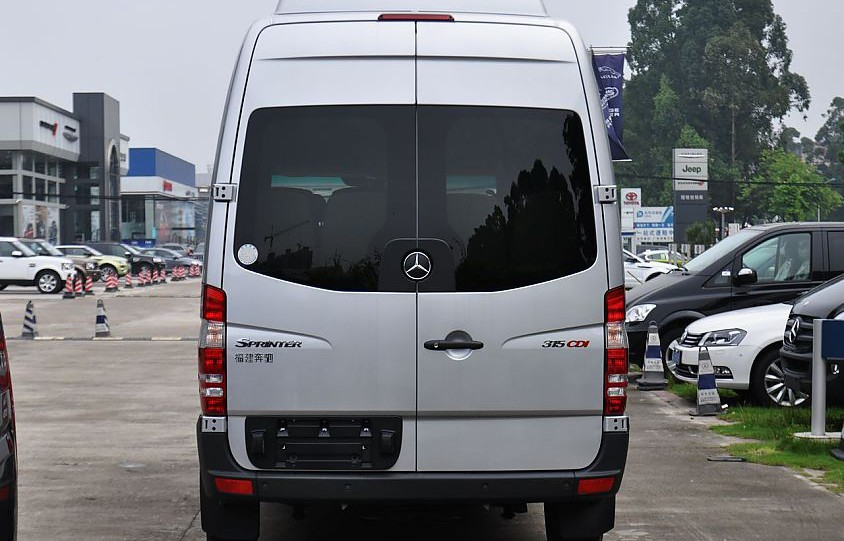

Type #6: fastback


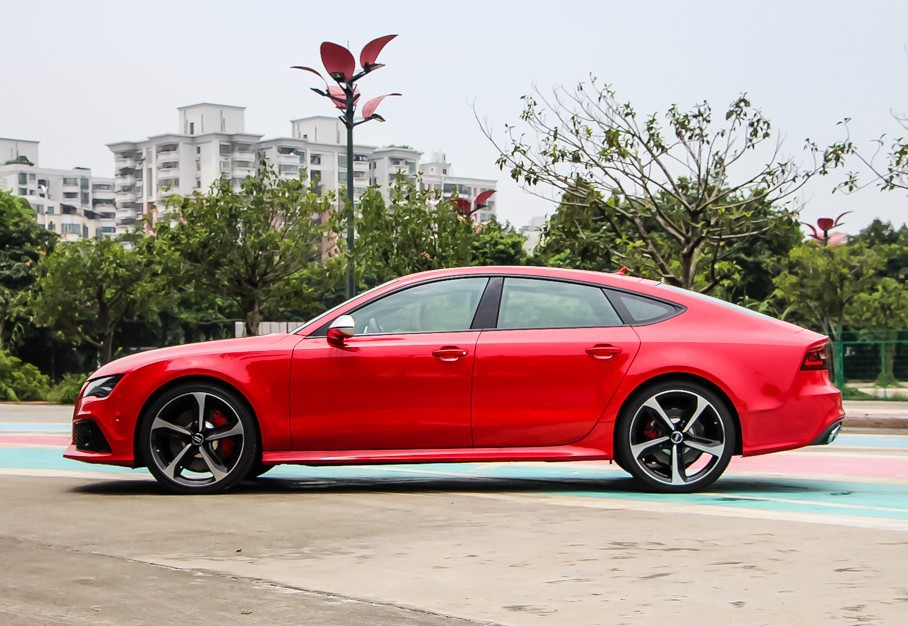

Type #7: estate


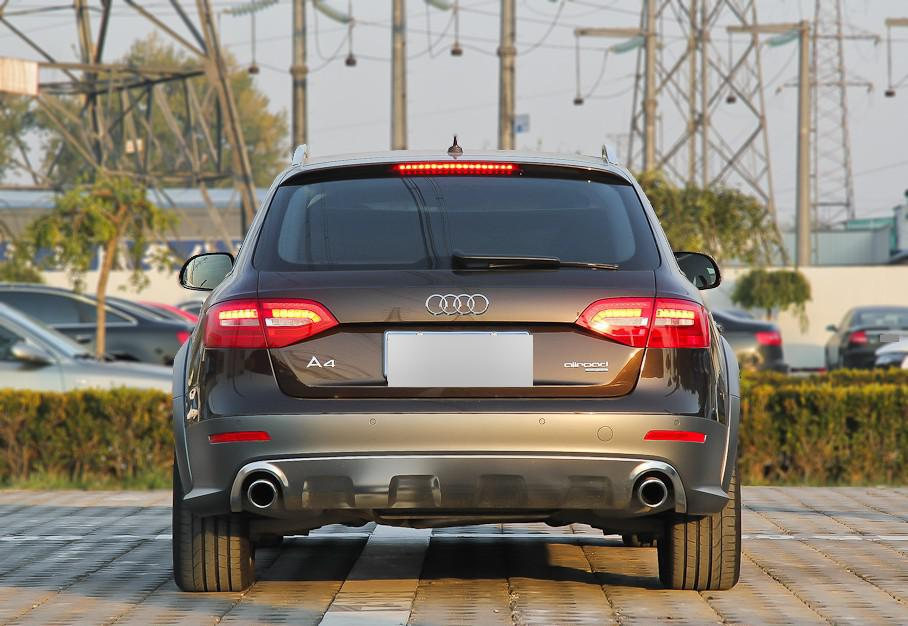

Type #8: pickup


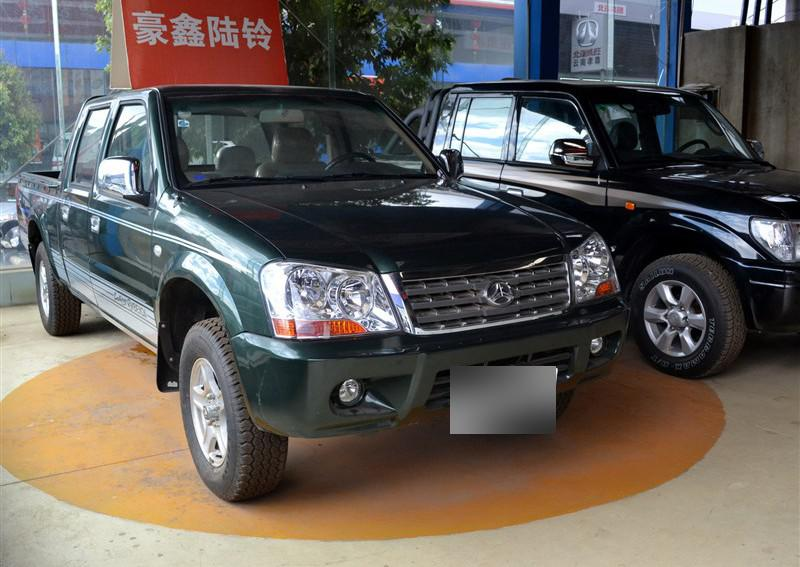

Type #9: hardtop convertible


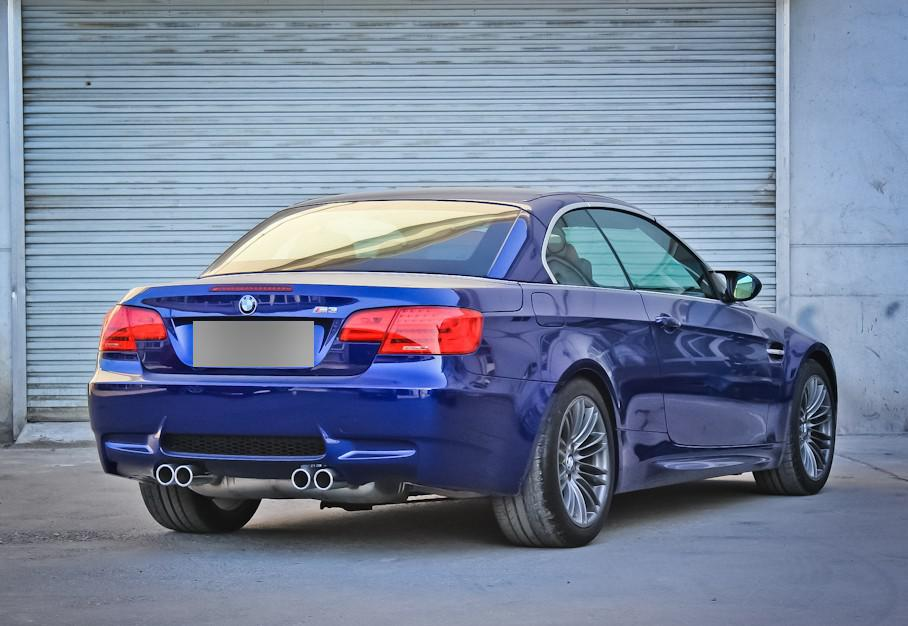

Type #10: sports


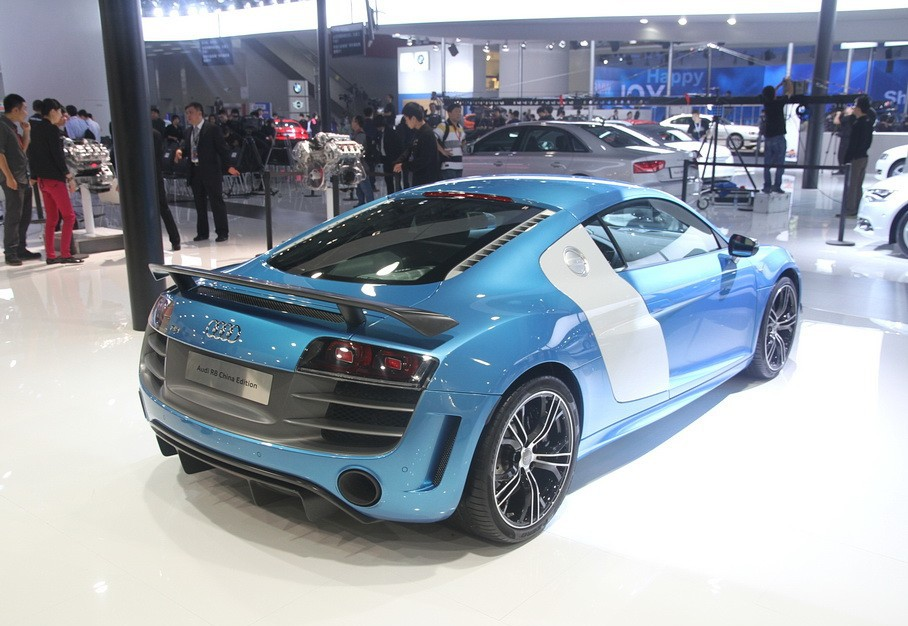

Type #11: crossover


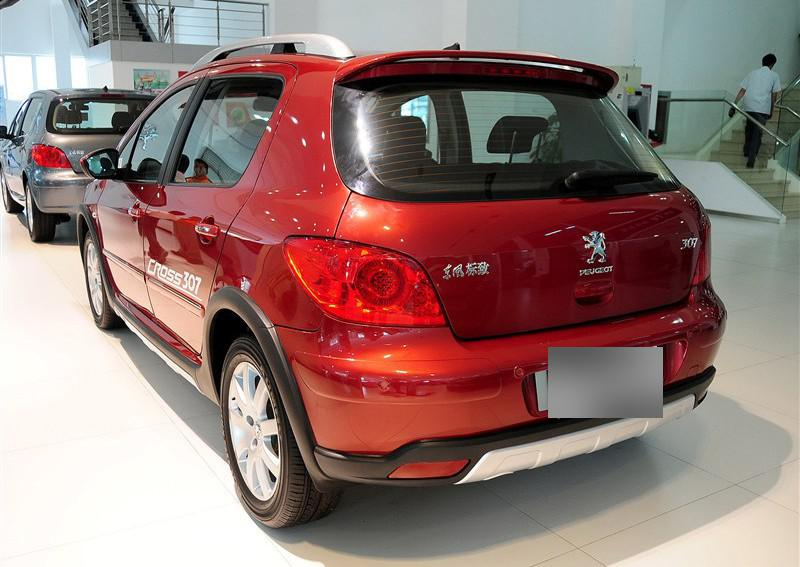

Type #12: convertible


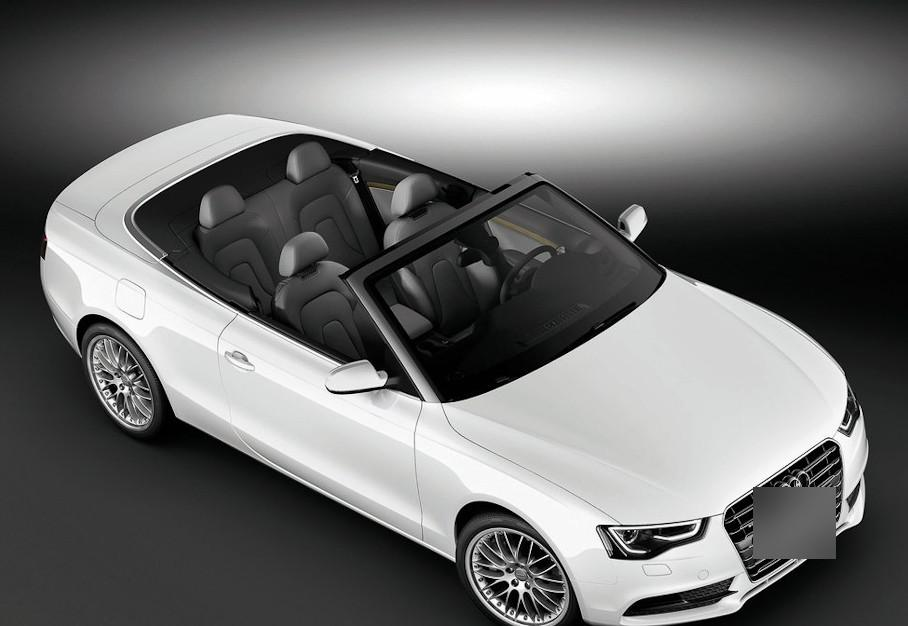

In [8]:
# View the first image from each

from IPython.display import display, Image

car_type = [(i+1, t) for i, t in car_type]

for i, t in car_type:
    print(f"Type #{i}: {t}")
    cur_df = df_attributes[df_attributes["type"] == i].iloc[0, :]
    cur_images = [im for im in images if im[1].split("/")[2] == cur_df["model_id"]]
    display(Image(cur_images[0][1]))

## Re-classify images

1. Upon a review of the `unknown` group, they are clearly images that resemble other classes. Let's create a new df that removes these from consideration.
2. Review images and create a `mapped_label` for each label, consolidating visually indistinguishable groups.

In [9]:
# 1. Remove unknown from the dataframe

print(f"Previously, there were {df_attributes.shape[0]:,.0f} models")
df_attributes_known = df_attributes[df_attributes["label"] != "unknown"]
print(f"Now, there are {df_attributes_known.shape[0]:,.0f} models")

Previously, there were 1,716 models
Now, there are 968 models


In [10]:
# 2. Create a mapped_label from manual image review and update in the dataframe

pd.options.mode.chained_assignment = None

mapped_labels = {

    # Convertibles contain sports cars (some hard top, some not)
    # We'll map them all to sports for simplicity of review
    "convertible": "sports_convertible",
    "hardtop convertible": "sports_convertible",
    "sports": "sports_convertible",

    # Crossovers are essentially hatchbacks (i.e., what we would consider a crossover is an SUV here)
    "crossover": "hatchback",
    "hatchback": "hatchback",

    # Estates are what we would call station wagons, so we'll rename
    "estate": "station_wagon",

    # Fastbacks are distinguishable from sedans only due to a smoother back, so we'll combine
    "fastback": "sedan",
    "sedan": "sedan",

    # Minibus we'll leave as is, as it's a super boxy van (similar to MPV but flatter top)
    "minibus": "minibus",

    # MPV we'll rename to minivans, though there are some images that do not have sliding doors
    "MPV": "mini_van",

    # Pickup is quite clear
    "pickup": "pickup",

    # SUV also contains what we'd call crossovers, so we'll rename
    "SUV": "suv_crossover",

}

df_attributes_known["mapped_label"] = df_attributes_known["label"].replace(mapped_labels)
pd.DataFrame(df_attributes_known["mapped_label"].value_counts()).reset_index()

,mapped_label,count
0,sedan,312
1,suv_crossover,200
2,hatchback,171
3,sports_convertible,94
4,minibus,71
5,mini_van,60
6,pickup,46
7,station_wagon,14


In [11]:
df_attributes_known[["type", "label", "mapped_label"]].drop_duplicates().sort_values("mapped_label")

,type,label,mapped_label
0,4,hatchback,hatchback
222,11,crossover,hatchback
124,1,MPV,mini_van
123,5,minibus,minibus
301,8,pickup,pickup
1,3,sedan,sedan
8,6,fastback,sedan
16,12,convertible,sports_convertible
25,10,sports,sports_convertible
65,9,hardtop convertible,sports_convertible


## Select sample

1. Randomly select car images
2. From the image path, assign that image a class
3. Save into a file structure

In [ ]:
# 1. Randomly select 9,700 car images (10% of total)


from collections import defaultdict
from random import sample, shuffle

# By total count

# N_IMAGES = 9_700
# sample_images = sample(images, k=20_000)  # Setting 20K as many will be "unknown" and filtered out 
sample_images = images  # To show there are about 97K messages remaining

# By class

CLASSES = list(set(df_attributes_known["mapped_label"].drop_duplicates()))

N_IMAGES_PER_CLASS = 1_200  # station wagons only have approximately 1,200 photos
image_counter = {c: 0 for c in CLASSES}
sample_images = images.copy()
shuffle(images)  # Using all and then getting N_IMAGES_PER_CLASS

In [ ]:
# 2. From the image path, assign the image a class

from tqdm import tqdm

# By class

sample_images_by_type = defaultdict(list)
for im in tqdm(sample_images):
    try:
        cur_model = im[1].split("/")[2]
        cur_type = df_attributes_known[df_attributes_known["model_id"] == cur_model]["mapped_label"].iloc[0]
        if image_counter[cur_type] >= N_IMAGES_PER_CLASS:
            continue
        sample_images_by_type[cur_type].append(im)
        image_counter[cur_type] += 1
    except IndexError:
        pass
    finally:
        if all(val >= N_IMAGES_PER_CLASS for val in image_counter.values()):
            break
sample_images_by_type = dict(sample_images_by_type)

In [ ]:
total = 0
for t, ims in sample_images_by_type.items():
    total += len(ims)
    print(f"{t} has {len(ims):,.0f} images")
print(f"\nIn total, there are {total:,.0f} images")

In [ ]:
# 3. Save them into a file structure

from shutil import copyfile

PARENT_DIR: str = "sample_balanced"

os.makedirs(PARENT_DIR, exist_ok=True)

def change_image_name(im: str) -> str:
    return "_".join(im.split("/")[1:])

for t, ims in sample_images_by_type.items():
    for im in ims:
        cur_im = change_image_name(im[1])
        try:
            copyfile(im[1], f"{PARENT_DIR}/{t}/{cur_im}")
        except IOError:
            os.makedirs(f"{PARENT_DIR}/{t}", exist_ok=True)
            copyfile(im[1], f"{PARENT_DIR}/{t}/{cur_im}")

In [ ]:
# QC

from glob import glob
from pathlib import Path

qc_images = [file for file in glob(f"{PARENT_DIR}/**/*.*", recursive=True) if Path(file).suffix in [".jpg", ".jpeg", ".png"]]
print(f"Exported {len(qc_images):,.0f} images")

## Get txt labels for all images

In [ ]:
from shutil import copyfile

PARENT_DIR: str = "sample_balanced"
SAMPLE_DIR = "labels_balanced"

os.makedirs(PARENT_DIR, exist_ok=True)

def change_image_name(im: str) -> str:
    return "_".join(im.split("/")[1:])

for cls, ims in tqdm(sample_images_by_type.items()):
    for im in ims:
        cur_label = im[1].replace("image/", "label/").split(".")[0] + ".txt"
        cur_path = change_image_name(im[1].replace("image/", "label/")).split(".")[0] + ".txt"
        try:
            copyfile(cur_label, f"{SAMPLE_DIR}/{cls}/{cur_path}")
        except IOError:
            os.makedirs(f"{SAMPLE_DIR}/{cls}", exist_ok=True)
            copyfile(cur_label, f"{SAMPLE_DIR}/{cls}/{cur_path}")

In [ ]:
# QC

from glob import glob
from pathlib import Path

SAMPLE_DIR = "labels_balanced"

qc_labels = [file for file in glob(f"{SAMPLE_DIR}/**/*.*", recursive=True) if Path(file).suffix == ".txt"]
print(f"Exported {len(qc_labels):,.0f} labels")

## Update `labels_balanced` to adhere to YOLO format

In [12]:
# Create dir

PARENT_DIR: str = "labels_balanced"
SAMPLE_DIR: str = "labels_balanced_updated"

os.makedirs(SAMPLE_DIR, exist_ok=True)

In [13]:
# Updated mapped labels

mapped_labels_v2 = {
    "minibus": "0",
    "sedan": "1",
    "hatchback": "2", 
    "suv_crossover": "3",
    "pickup": "4",
    "station_wagon": "5",
    "mini_van": "6",
    "sports_convertible": "7",
}

In [14]:
# Convert bounding boxes to YOLO label

def convert_to_yolo_format(xmin, ymin, xmax, ymax, img_width, img_height):

    # Calculate the center of the bounding box
    x_center = (xmin + xmax) / 2.0
    y_center = (ymin + ymax) / 2.0

    # Calculate width and height of the bounding box
    bbox_width = xmax - xmin
    bbox_height = ymax - ymin

    # Normalize the coordinates by image dimensions
    x_center /= img_width
    y_center /= img_height
    bbox_width /= img_width
    bbox_height /= img_height

    return x_center, y_center, bbox_width, bbox_height

In [17]:
# Process label files

import cv2
from tqdm import tqdm

def process_label_files(image_dir, label_dir):
    """Process label files and convert them to YOLO format."""
    for class_name in tqdm(os.listdir(image_dir)):
        image_class_path = os.path.join(image_dir, class_name)
        label_class_path = os.path.join(label_dir, class_name)
        class_label = mapped_labels_v2[class_name]

        if not os.path.isdir(image_class_path):
            continue

        for image_file in os.listdir(image_class_path):
            if not image_file.endswith(('.jpg', '.jpeg', '.png')):
                continue

            # Image file path
            img_path = os.path.join(image_class_path, image_file)

            # Read the image to get its dimensions
            img = cv2.imread(img_path)
            if img is None:
                print(f"Error reading image {img_path}")
                continue

            img_height, img_width = img.shape[:2]

            # Corresponding label file
            label_file = os.path.splitext(image_file)[0] + '.txt'
            label_file_path = os.path.join(label_class_path, label_file)

            # Check if label file exists
            if not os.path.exists(label_file_path):
                print(f"Missing label file for {img_path}")
                continue

            # Read label data and convert
            new_labels = []
            with open(label_file_path, 'r') as f:
                lines = f.readlines()

                # Assume first line is class id, and subsequent lines are bounding box coordinates
                if len(lines) < 2:
                    print(f"Invalid label format for {label_file_path}")
                    continue

                # First line is the class index
                class_id = int(lines[0].strip())

                # The following line(s) should contain the bounding box info
                for line in lines[2:]:
                    parts = line.strip().split()
                    if len(parts) != 4:
                        print(f"Invalid bounding box format in {label_file_path}")
                        continue

                    # Read bounding box coordinates
                    xmin, ymin, xmax, ymax = map(int, parts)

                    # Convert bounding box to YOLO format
                    x_center, y_center, bbox_width, bbox_height = convert_to_yolo_format(
                        xmin, ymin, xmax, ymax, img_width, img_height)

                    # Append the formatted string
                    new_labels.append(f"{class_label} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}")

            # Write the new label format to the same file
            with open(label_file_path, 'w') as f:
                for label in new_labels:
                    f.write(label + '\n')

In [18]:
process_label_files(
    image_dir=os.path.join(os.getcwd(), 'sample_balanced'),
    label_dir=os.path.join(os.getcwd(), 'labels_balanced')
)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:13<00:00,  1.68s/it]


In [ ]:
# Iterate through the files and re-create them

for _dir in tqdm(os.listdir(PARENT_DIR)):
    _label = mapped_labels_v2[_dir]
    os.makedirs(os.path.join(os.getcwd(), SAMPLE_DIR, _dir), exist_ok=True)
    for file in os.listdir(os.path.join(os.getcwd(), PARENT_DIR, _dir)):
        _path = f"{os.getcwd()}/{PARENT_DIR}/{_dir}/{file}"
        output_path = _path.replace("/labels_balanced", "/labels_balanced_updated")
        with open(_path, "r") as f:
            _ = f.readline()
            _ = f.readline()
            _bbox = f.readline().strip()
        with open(output_path, "w+") as f:
            f.write(f"{_label} {_bbox}")

In [ ]:
with open(_path, "r") as f:
    _bbox = f.readlines()

In [ ]:
_bbox

In [ ]:
# QC

from glob import glob
from pathlib import Path
from collections import defaultdict

qc_files = [f for f in glob(f"{SAMPLE_DIR}/**/*.*", recursive=True) if Path(f).suffix == ".txt"]
qc_results = defaultdict(set)

for file in tqdm(qc_files):
    _label = Path(file).parts[1]
    with open(file, "r") as f:
        _val = f.readline().strip()[0]
    qc_results[_label].add(_val)

qc_results = dict(qc_results)
qc_results

## Plot Distributions of Images

In [ ]:
# For all

# sample_images_by_type = defaultdict(list)
# sampled_images = 0
# for im in tqdm(sample_images):
#     try:
#         cur_model = im[1].split("/")[2]
#         cur_type = df_attributes_known[df_attributes_known["model_id"] == cur_model]["mapped_label"].iloc[0]
#         sample_images_by_type[cur_type].append(im)
#         sampled_images += 1
#     except IndexError:
#         pass
# sample_images_by_type = dict(sample_images_by_type)

all_images = []
for cls, imgs in sample_images_by_type.items():
    all_images.append((cls, len(imgs)))
df_all_images = pd.DataFrame(all_images, columns=["class", "count"])
df_all_images.sort_values("class", inplace=True)

In [ ]:
# For sample

import pandas as pd
from collections import defaultdict
from pathlib import Path

sample_images = defaultdict(int)

for dir in os.listdir("sample_balanced"):
    for im in os.listdir(f"sample_balanced/{dir}"):
        if Path(im).suffix in [".jpeg", ".jpg", ".png"]:
            sample_images[dir] += 1

df_sample_images = pd.DataFrame(zip(sample_images.keys(), sample_images.values()), columns=["class", "count"])
df_sample_images.sort_values("class", inplace=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(df_all_images))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(figsize=(6, 4))

bars = ax.bar(x + width, df_all_images["count"], width, label=df_all_images["class"])
ax.bar_label(bars, padding=0, fmt="{:,.0f}")
bars = ax.bar(x + width * 2, df_sample_images["count"], width, label=df_sample_images["class"], color="yellow")
ax.set_ylabel('# of images')
ax.set_title('Car Images by Class\nBalanced to 1,200 images per class')
ax.set_xticks(x + width, df_all_images["class"], rotation=90)